# Bayesian Temporal Matrix Factorization

**Published**: October 8, 2019

**Author**: Xinyu Chen [[**GitHub homepage**](https://github.com/xinychen)]

**Download**: This Jupyter notebook is at our GitHub repository. If you want to evaluate the code, please download the notebook from the [**tensor-learning**](https://github.com/xinychen/tensor-learning/blob/master/content/BTMF.ipynb) repository.

This notebook shows how to implement the Bayesian Temporal Matrix Factorization (BTMF) model on some real-world data sets. To overcome the problem of missing values within multivariate time series data, this model takes into account both low-rank structure and time series autoregression. For an in-depth discussion of BTMF, please see [1].

<div class="alert alert-block alert-info">
<font color="black">
<b>[1]</b> Xinyu Chen, Lijun Sun (2019). <b>Bayesian temporal factorization for multidimensional time series prediction</b>. arXiv:1910.06366. <a href="https://arxiv.org/pdf/1910.06366.pdf" title="PDF"><b>[PDF]</b></a> 
</font>
</div>

## Abstract

Large-scale and multidimensional spatiotemporal data sets are becoming ubiquitous in many real-world applications such as monitoring traffic and air quality. Making predictions on these time series has become a critical challenge due to not only the large-scale and high-dimensional nature but also the considerable amount of missing data. In this work, we propose a Bayesian Temporal Matrix Factorization (BTMF) model for modeling multidimensional time series - and in particular spatiotemporal data - in the presence of missing data. By integrating low-rank matrix factorization and vector autoregressive (VAR) process into a single probabilistic graphical model, our model can effectively perform predictions without imputing those missing values. We develop efficient Gibbs sampling algorithms for model inference and test the proposed BTMF on several real-world spatiotemporal data sets for both missing data imputation and short-term rolling prediction tasks. This post is mainly about BTMF and its **`Python`** implementation with an application of spatiotemporal data imputation.

## 1 Motivation



## 2 Problem Description

We assume a spatiotemporal setting for multidimensional time series data throughout this work. In general, modern spatiotemporal data sets collected from sensor networks can be organized as matrix time series. For example, we can denote by matrix $Y\in\mathbb{R}^{N\times T}$ a multivariate time series collected from $N$ locations/sensors on $T$ time points, with each row $$\boldsymbol{y}_{i}=\left(y_{i,1},y_{i,2},...,y_{i,t-1},y_{i,t},y_{i,t+1},...,y_{i,T}\right)$$
corresponding to the time series collected at location $i$.

As mentioned, making accurate predictions on incomplete time series is very challenging, while missing data problem is almost inevitable in real-world applications. Figure 1 illustrates the prediction problem for incomplete time series data. Here we use $(i,t)\in\Omega$ to index the observed entries in matrix $Y$.

<img src="../images/graphical_matrix_time_series.png" alt="drawing" width="500"/>

> **Figure 1**: Illustration of multivariate time series and the prediction problem in the presence of missing values (green: observed data; white: missing data; red: prediction).


## 3 Model Description

Given a partially observed spatiotemporal matrix $Y\in\mathbb{R}^{N \times T}$, one can factorize it into a spatial factor matrix $W\in\mathbb{R}^{R \times N}$ and a temporal factor matrix $X\in\mathbb{R}^{R \times T}$ following general matrix factorization model:
\begin{equation}
Y\approx W^{\top}X,
\label{btmf_equation1}
\end{equation}
and element-wise, we have
\begin{equation}
y_{it}\approx \boldsymbol{w}_{i}^\top\boldsymbol{x}_{t}, \quad \forall (i,t),
\label{btmf_equation2}
\end{equation}
where vectors $\boldsymbol{w}_{i}$ and $\boldsymbol{x}_{t}$ refer to the $i$-th column of $W$ and the $t$-th column of $X$, respectively.

The standard matrix factorization model is a good approach to deal with the missing data problem; however, it cannot capture the dependencies among different columns in $X$, which are critical in modeling time series data. To better characterize the temporal dependencies and impose temporal smoothness, a novel AR regularizer is introduced on $X$ in TRMF (i.e., Temporal Regularizer Matrix Factorization proposed by [Yu et al., 2016](https://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf)):
\begin{equation} \label{equ:VAR}
\begin{aligned}
    \boldsymbol{x}_{t+1}&=\sum\nolimits_{k=1}^{d}A_{k}\boldsymbol{x}_{t+1-h_k}+\boldsymbol{\epsilon}_t, \\
    &=A^\top \boldsymbol{v}_{t+1}+\boldsymbol{\epsilon}_{t}, \\
\end{aligned}
\end{equation}
where $\mathcal{L}=\left\{h_1,\ldots,h_k,\ldots,h_d\right\}$ is a lag set ($d$ is the order of this AR model), each $A_k$ ($k\in\left\{1,...,d\right\}$) is a $R\times R$ coefficient matrix, and $\boldsymbol{\epsilon}_t$ is a zero mean Gaussian noise vector. For brevity, matrix $A\in \mathbb{R}^{(R d) \times R}$ and vector $\boldsymbol{v}_{t+1}\in \mathbb{R}^{(R d) \times 1}$ are defined as
\begin{equation*}
A=\left[A_{1}, \ldots, A_{d}\right]^{\top} ,\quad \boldsymbol{v}_{t+1}=\left[\begin{array}{c}{\boldsymbol{x}_{t+1-h_1}} \\ {\vdots} \\ {\boldsymbol{x}_{t+1-h_d}}\end{array}\right] .
\end{equation*}

<img src="../images/rolling_prediction.png" alt="drawing" width="400"/>

> **Figure 2**: A graphical illustration of the rolling prediction scheme using BTMF (with VAR process) (green: observed data; white: missing data; red: prediction).

In [Yu et al., 2016](https://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf), to avoid overfitting and reduce the number of parameters, the coefficient matrix in TRMF is further assumed to be a diagonal $A_k=\text{diag}(\boldsymbol{\theta}_{k})$. Therefore, they have
\begin{equation} \label{equ:AR}
\boldsymbol{x}_{t+1}=\boldsymbol{\theta}_{1}\circledast\boldsymbol{x}_{t+1-h_1}+\cdots+\boldsymbol{\theta}_{d}\circledast\boldsymbol{x}_{t+1-h_d}+\boldsymbol{\epsilon}_t,
\end{equation}
where the symbol $\circledast$ denotes the element-wise Hadamard product. However, unlike Equation (4), a vector autoregressive (VAR) model in Equation (3) is actually more powerful for capturing multivariate time series patterns. 

<img src="../images/rolling_prediction_strategy.png" alt="drawing" width="400"/>

> **Figure 3**: A graphical illustration of the rolling prediction scheme using BTMF (with AR process) (green: observed data; white: missing data; red: prediction).

In the following, we first introduce a Bayesian temporal matrix factorization model with an autoregressive model given in Equation (4), and then discuss another model with a vector autoregressive (VAR) model shown in Equation (3).



## 4 Bayesian Sequential Matrix Factorization (BSMF)

## 5 Bayesian Temporal Matrix Factorization with Vector Autoregressive Model

### 5.1 Model Specification

Following the general Bayesian probabilistic matrix factorization models (e.g., BPMF proposed by [Salakhutdinov & Mnih, 2008](https://www.cs.toronto.edu/~amnih/papers/bpmf.pdf)), we assume that each observed entry in $Y$ follows a Gaussian distribution with precision $\tau$:
\begin{equation}
y_{i,t}\sim\mathcal{N}\left(\boldsymbol{w}_i^\top\boldsymbol{x}_t,\tau^{-1}\right),\quad \left(i,t\right)\in\Omega.
\label{btmf_equation3}
\end{equation}

On the spatial dimension, we use a simple Gaussian factor matrix without imposing any dependencies explicitly:
\begin{equation}
\boldsymbol{w}_i\sim\mathcal{N}\left(\boldsymbol{\mu}_{w},\Lambda_w^{-1}\right),
\end{equation}
and we place a conjugate Gaussian-Wishart prior on the mean vector and the precision matrix:
\begin{equation}
\boldsymbol{\mu}_w | \Lambda_w \sim\mathcal{N}\left(\boldsymbol{\mu}_0,(\beta_0\Lambda_w)^{-1}\right),\Lambda_w\sim\mathcal{W}\left(W_0,\nu_0\right),
\end{equation}
where $\boldsymbol{\mu}_0\in \mathbb{R}^{R}$ is a mean vector, $\mathcal{W}\left(W_0,\nu_0\right)$ is a Wishart distribution with a $R\times R$ scale matrix $W_0$ and $\nu_0$ degrees of freedom.

In modeling the temporal factor matrix $X$, we re-write the VAR process as:
\begin{equation}
\begin{aligned}
\boldsymbol{x}_{t}&\sim\begin{cases}
\mathcal{N}\left(\boldsymbol{0},I_R\right),&\text{if $t\in\left\{1,2,...,h_d\right\}$}, \\
\mathcal{N}\left(A^\top \boldsymbol{v}_{t},\Sigma\right),&\text{otherwise},\\
\end{cases}\\
\end{aligned}
\label{btmf_equation5}
\end{equation}

Since the mean vector is defined by VAR, we need to place the conjugate matrix normal inverse Wishart (MNIW) prior on the coefficient matrix $A$ and the covariance matrix $\Sigma$ as follows,
\begin{equation}
\begin{aligned}
A\sim\mathcal{MN}_{(Rd)\times R}\left(M_0,\Psi_0,\Sigma\right),\quad
\Sigma \sim\mathcal{IW}\left(S_0,\nu_0\right), \\
\end{aligned}
\end{equation}
where the probability density function for the $Rd$-by-$R$ random matrix $A$ has the form:
\begin{equation}
\begin{aligned}
&p\left(A\mid M_0,\Psi_0,\Sigma\right) \\
=&\left(2\pi\right)^{-R^2d/2}\left|\Psi_0\right|^{-R/2}\left|\Sigma\right|^{-Rd/2} \\
&\times \exp\left(-\frac{1}{2}\text{tr}\left[\Sigma^{-1}\left(A-M_0\right)^{\top}\Psi_{0}^{-1}\left(A-M_0\right)\right]\right), \\
\end{aligned}
\label{mnpdf}
\end{equation}
where $\Psi_0\in\mathbb{R}^{(Rd)\times (Rd)}$ and $\Sigma\in\mathbb{R}^{R\times R}$ are played as covariance matrices.

For the only remaining parameter $\tau$, we place a Gamma prior  $\tau\sim\text{Gamma}\left(\alpha,\beta\right)$ where $\alpha$ and $\beta$ are the shape and rate parameters, respectively. 

The above specifies the full generative process of BTMF, and we could also see the Bayesian graphical model shown in Figure 4. Several parameters are introduced to define the prior distributions for hyperparameters, including $\boldsymbol{\mu}_{0}$, $W_0$, $\nu_0$, $\beta_0$, $\alpha$, $\beta$, $M_0$, $\Psi_0$, and $S_0$. These parameters need to provided in advance when training the model. However, it should be noted that the specification of these parameters has little impact on the final results, as the training data will play a much more important role in defining the posteriors of the hyperparameters.

<img src="../images/btmf_net.png" alt="drawing" width="450"/>

> **Figure 4**: An overview graphical model of BTMF (time lag set: $\left\{1,2,...,d\right\}$). The shaded nodes ($y_{i,t}$) are the observed data in $\Omega$.


### 5.2 Model Inference



Given the complex structure of BTMF, it is intractable to write down the posterior distribution. Here we rely on the MCMC technique for Bayesian learning. In detail, we introduce a Gibbs sampling algorithm by deriving the full conditional distributions for all parameters and hyperparameters. Thanks to the use of conjugate priors in Figure 4, we can actually write down all the conditional distributions analytically. Below we summarize the Gibbs sampling procedure.  


#### 1) Sampling Factor Matrix $W$ and Its Hyperparameters



> For programming convenience, we use $W\in\mathbb{R}^{N\times R}$ to replace $W\in\mathbb{R}^{R\times N}$.

In [10]:
import numpy as np
from numpy.linalg import inv as inv
from numpy.random import multivariate_normal as mvnrnd
from scipy.stats import wishart

def kr_prod(a, b):
    return np.einsum('ir, jr -> ijr', a, b).reshape(a.shape[0] * b.shape[0], -1)

def cov_mat(mat):
    new_mat = mat - np.mean(mat, axis = 0)
    return np.einsum('ti, tj -> ij', new_mat, new_mat)

def sample_factor_w(sparse_mat, W, X, tau, beta0 = 1, vargin = 0):
    """Sampling N-by-R factor matrix W and its hyperparameters (mu_w, Lambda_w)."""
    
    dim1, rank = W.shape
    binary_mat = sparse_mat.copy()
    binary_mat[binary_mat != 0] = 1
    W_bar = np.mean(W, axis = 0)
    var_mu_hyper = (dim1 * W_bar) / (dim1 + beta0)
    var_W_hyper = inv(np.eye(rank) + cov_mat(W) + dim1 * beta0 / (dim1 + beta0) * np.outer(W_bar, W_bar))
    var_Lambda_hyper = wishart(df = dim1 + rank, scale = var_W_hyper, seed = None).rvs()
    var_mu_hyper = mvnrnd(var_mu_hyper, inv((dim1 + beta0) * var_Lambda_hyper))
    
    if dim1 * rank ** 2 > 1e+8:
        vargin = 1
    
    if vargin == 0:
        binary_mat = sparse_mat.copy()
        binary_mat[binary_mat != 0] = 1
        var1 = X.T
        var2 = kr_prod(var1, var1)
        var3 = tau * (var2 @ binary_mat.T).reshape([rank, rank, dim1]) + np.dstack([var_Lambda_hyper] * dim1)
        var4 = tau * var1 @ sparse_mat.T + np.dstack([var_Lambda_hyper @ var_mu_hyper] * dim1)[0, :, :]
        for i in range(dim1):
            inv_var_Lambda = inv(var3[:, :, i])
            W[i, :] = mvnrnd(inv_var_Lambda @ var4[:, i], inv_var_Lambda)
    elif vargin == 1:
        for i in range(dim1):
            pos0 = np.where(sparse_mat[i, :] != 0)
            Xt = X[pos0[0], :]
            var_mu = tau * Xt.T @ sparse_mat[i, pos0[0]] + var_Lambda_hyper @ var_mu_hyper
            inv_var_Lambda = inv(tau * Xt.T @ Xt + var_Lambda_hyper)
            W[i, :] = mvnrnd(inv_var_Lambda @ var_mu, inv_var_Lambda)
    
    return W

#### 2) Sampling VAR Coefficients $A$ and Its Hyperparameters

**Foundations of VAR**

Vector autoregression (VAR) is a multivariate extension of autoregression (AR). Formally, VAR for $R$-dimensional vectors $\boldsymbol{x}_{t}$ can be written as follows,
\begin{equation}
\begin{aligned}
\boldsymbol{x}_{t}&=A_{1} \boldsymbol{x}_{t-h_1}+\cdots+A_{d} \boldsymbol{x}_{t-h_d}+\boldsymbol{\epsilon}_{t}, \\
&= A^\top \boldsymbol{v}_{t}+\boldsymbol{\epsilon}_{t},~t=h_d+1, \ldots, T, \\
\end{aligned}
\end{equation}
where
\begin{equation}
A=\left[A_{1}, \ldots, A_{d}\right]^{\top} \in \mathbb{R}^{(R d) \times R},\quad \boldsymbol{v}_{t}=\left[\begin{array}{c}{\boldsymbol{x}_{t-h_1}} \\ {\vdots} \\ {\boldsymbol{x}_{t-h_d}}\end{array}\right] \in \mathbb{R}^{(R d) \times 1}.
\end{equation}

In the following, if we define
\begin{equation}
Z=\left[\begin{array}{c}{\boldsymbol{x}_{h_d+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{x}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{(T-h_d) \times R},\quad Q=\left[\begin{array}{c}{\boldsymbol{v}_{h_d+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{v}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{(T-h_d) \times(R d)},
\end{equation}
then, we could write the above mentioned VAR as
\begin{equation}
\underbrace{Z}_{(T-h_d)\times R}\approx \underbrace{Q}_{(T-h_d)\times (Rd)}\times \underbrace{A}_{(Rd)\times R}.
\end{equation}

> To include temporal factors $\boldsymbol{x}_{t},t=1,...,h_d$, we also define $$Z_0=\left[\begin{array}{c}{\boldsymbol{x}_{1}^{\top}} \\ {\vdots} \\ {\boldsymbol{x}_{h_d}^{\top}}\end{array}\right] \in \mathbb{R}^{h_d \times R}.$$



**Build a Bayesian VAR on temporal factors $\boldsymbol{x}_{t}$**
\begin{equation}
\begin{aligned}
\boldsymbol{x}_{t}&\sim\begin{cases}\mathcal{N}\left(A^\top \boldsymbol{v}_{t},\Sigma\right),~\text{if $t\in\left\{h_d+1,...,T\right\}$},\\{\mathcal{N}\left(\boldsymbol{0},I_R\right),~\text{otherwise}}.\end{cases}\\
A&\sim\mathcal{MN}_{(Rd)\times R}\left(M_0,\Psi_0,\Sigma\right), \\
\Sigma &\sim\mathcal{IW}\left(S_0,\nu_0\right), \\
\end{aligned}
\end{equation}
where
\begin{equation}
\begin{aligned}
&\mathcal{M N}_{(R d) \times R}\left(A | M_{0}, \Psi_{0}, \Sigma\right)\\
\propto|&\Sigma|^{-R d / 2} \exp \left(-\frac{1}{2} \operatorname{tr}\left[\Sigma^{-1}\left(A-M_{0}\right)^{\top} \Psi_{0}^{-1}\left(A-M_{0}\right)\right]\right), \\
\end{aligned}
\end{equation}
and
\begin{equation}
\mathcal{I} \mathcal{W}\left(\Sigma | S_{0}, \nu_{0}\right) \propto|\Sigma|^{-\left(\nu_{0}+R+1\right) / 2} \exp \left(-\frac{1}{2} \operatorname{tr}\left(\Sigma^{-1}S_{0}\right)\right).
\end{equation}


**Likelihood from temporal factors $\boldsymbol{x}_{t}$**
\begin{equation}
\begin{aligned}
&\mathcal{L}\left(X\mid A,\Sigma\right) \\
\propto &\prod_{t=1}^{h_d}p\left(\boldsymbol{x}_{t}\mid \Sigma\right)\times \prod_{t=h_d+1}^{T}p\left(\boldsymbol{x}_{t}\mid A,\Sigma\right) \\
\propto &\left|\Sigma\right|^{-T/2}\exp\left\{-\frac{1}{2}\sum_{t=h_d+1}^{T}\left(\boldsymbol{x}_{t}-A^\top \boldsymbol{v}_{t}\right)^\top\Sigma^{-1}\left(\boldsymbol{x}_{t}-A^\top \boldsymbol{v}_{t}\right)\right\} \\
\propto &\left|\Sigma\right|^{-T/2}\exp\left\{-\frac{1}{2}\text{tr}\left[\Sigma^{-1}\left(Z_0^\top Z_0+\left(Z-QA\right)^\top \left(Z-QA\right)\right)\right]\right\}
\end{aligned}
\end{equation}


**Posterior distribution**

Consider
\begin{equation}
\begin{aligned}
&\left(A-M_{0}\right)^{\top} \Psi_{0}^{-1}\left(A-M_{0}\right)+S_0+Z_0^\top Z_0+\left(Z-QA\right)^\top \left(Z-QA\right) \\
=&A^\top\left(\Psi_0^{-1}+Q^\top Q\right)A-A^\top\left(\Psi_0^{-1}M_0+Q^\top Z\right) \\
&-\left(\Psi_0^{-1}M_0+Q^\top Z\right)^\top A \\
&+\left(\Psi_0^{-1}M_0+Q^\top Z\right)^\top\left(\Psi_0^{-1}+Q^\top Q\right)\left(\Psi_0^{-1}M_0+Q^\top Z\right) \\
&-\left(\Psi_0^{-1}M_0+Q^\top Z\right)^\top\left(\Psi_0^{-1}+Q^\top Q\right)\left(\Psi_0^{-1}M_0+Q^\top Z\right) \\
&+M_0^\top\Psi_0^{-1}M_0+S_0+Z_0^\top Z_0+Z^\top Z \\
=&\left(A-M^{*}\right)^\top\left(\Psi^{*}\right)^{-1}\left(A-M^{*}\right)+S^{*}, \\
\end{aligned}
\end{equation}
which is in the form of $\mathcal{MN}\left(\cdot\right)$ and $\mathcal{IW}\left(\cdot\right)$.

The $Rd$-by-$R$ matrix $A$ has a matrix normal distribution, and $R$-by-$R$ covariance matrix $\Sigma$ has an inverse Wishart distribution, that is,
\begin{equation}
A \sim \mathcal{M N}_{(R d) \times R}\left(M^{*}, \Psi^{*}, \Sigma\right), \quad \Sigma \sim \mathcal{I} \mathcal{W}\left(S^{*}, \nu^{*}\right),
\end{equation}
with
\begin{equation}
\begin{cases}
{\Psi^{*}=\left(\Psi_{0}^{-1}+Q^{\top} Q\right)^{-1}}, \\ {M^{*}=\Psi^{*}\left(\Psi_{0}^{-1} M_{0}+Q^{\top} Z\right)}, \\ {S^{*}=S_{0}+Z^\top Z+M_0^\top\Psi_0^{-1}M_0-\left(M^{*}\right)^\top\left(\Psi^{*}\right)^{-1}M^{*}}, \\ 
{\nu^{*}=\nu_{0}+T-h_d}.
\end{cases}
\end{equation}

In [11]:
from scipy.stats import invwishart

def mnrnd(M, U, V):
    """
    Generate matrix normal distributed random matrix.
    M is a m-by-n matrix, U is a m-by-m matrix, and V is a n-by-n matrix.
    """
    dim1, dim2 = M.shape
    X0 = np.random.rand(dim1, dim2)
    P = np.linalg.cholesky(U)
    Q = np.linalg.cholesky(V)
    
    return M + np.matmul(np.matmul(P, X0), Q.T)

def sample_var_coefficient(X, time_lags):
    dim2, rank = X.shape
    d = time_lags.shape[0]
    Z_mat = X[np.max(time_lags) : dim2, :]
    Q_mat = X[np.max(time_lags) - time_lags[0] : dim2 - time_lags[0], :]
    for k in range(1, d):
        Q_mat = np.append(Q_mat, X[np.max(time_lags) - time_lags[k] : dim2 - time_lags[k], :], axis = 1)
    var_Psi0 = np.eye(rank * d) + Q_mat.T @ Q_mat
    var_Psi = inv(var_Psi0)
    var_M = var_Psi @ (Q_mat.T @ Z_mat)
    var_S = np.eye(rank) + Z_mat.T @ Z_mat - var_M.T @ var_Psi0 @ var_M
    Sigma = invwishart(df = rank + dim2 - np.max(time_lags), scale = var_S, seed = None).rvs()
    
    return mnrnd(var_M, var_Psi, Sigma), Sigma

#### 3) Sampling Factor Matrix $X$

**Posterior distribution**
\begin{equation}
\begin{aligned}
y_{it}&\sim\mathcal{N}\left(\boldsymbol{w}_{i}^\top\boldsymbol{x}_{t},\tau^{-1}\right),~\left(i,t\right)\in\Omega, \\
\boldsymbol{x}_{t}&\sim\begin{cases}\mathcal{N}\left(\sum_{k=1}^{d}A_{k} \boldsymbol{x}_{t-h_k},\Sigma\right),~\text{if $t\in\left\{h_d+1,...,T\right\}$},\\{\mathcal{N}\left(\boldsymbol{0},I\right),~\text{otherwise}}.\end{cases}\\
\end{aligned}
\end{equation}

If $t\in\left\{1,...,h_d\right\}$, parameters of the posterior distribution $\mathcal{N}\left(\boldsymbol{x}_{t}\mid \boldsymbol{\mu}_{t}^{*},\Sigma_{t}^{*}\right)$ are
\footnotesize{
\begin{equation}
\begin{aligned}
\Sigma_{t}^{*}&=\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} {A}_{k}^{\top} \Sigma^{-1} A_{k}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}\boldsymbol{w}_{i}^\top+I\right)^{-1}, \\
\boldsymbol{\mu}_{t}^{*}&=\Sigma_{t}^{*}\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} A_{k}^{\top} \Sigma^{-1} \boldsymbol{\psi}_{t+h_{k}}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}y_{it}\right). \\
\end{aligned}
\end{equation}

If $t\in\left\{h_d+1,...,T\right\}$, then parameters of the posterior distribution $\mathcal{N}\left(\boldsymbol{x}_{t}\mid \boldsymbol{\mu}_{t}^{*},\Sigma_{t}^{*}\right)$ are
\begin{equation}
\begin{aligned}
\Sigma_{t}^{*}&=\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} {A}_{k}^{\top} \Sigma^{-1} A_{k}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}\boldsymbol{w}_{i}^\top+\Sigma^{-1}\right)^{-1}, \\
\boldsymbol{\mu}_{t}^{*}&=\Sigma_{t}^{*}\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} A_{k}^{\top} \Sigma^{-1} \boldsymbol{\psi}_{t+h_{k}}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}y_{it}+\Sigma^{-1}\sum_{k=1}^{d}A_{k}\boldsymbol{x}_{t-h_k}\right), \\
\end{aligned}
\end{equation}
where
$$\boldsymbol{\psi}_{t+h_k}=\boldsymbol{x}_{t+h_k}-\sum_{l=1,l\neq k}^{d}A_{l}\boldsymbol{x}_{t+h_k-h_l}.$$



In [12]:
def sample_factor_x(sparse_mat, time_lags, W, X, tau, A, Lambda_x, vargin = 0):
    dim2, rank = X.shape
    d = time_lags.shape[0]
    A0 = np.dstack([A] * d)
    for k in range(d):
        A0[k * rank : (k + 1) * rank, :, k] = 0
    mat0 = Lambda_x @ A.T
    mat1 = np.einsum('kij, jt -> kit', A.reshape([d, rank, rank]), Lambda_x)
    mat2 = np.einsum('kit, kjt -> ij', mat1, A.reshape([d, rank, rank]))
    
    if dim2 * rank ** 2 > 1e+8:
        vargin = 1

    if vargin == 0:
        binary_mat = sparse_mat.copy()
        binary_mat[binary_mat != 0] = 1
        var1 = W.T
        var2 = kr_prod(var1, var1)
        var3 = tau * (var2 @ binary_mat).reshape([rank, rank, dim2]) + np.dstack([Lambda_x] * dim2)
        var4 = tau * var1 @ sparse_mat
    for t in range(dim2):
        Mt = np.zeros((rank, rank))
        Nt = np.zeros(rank)
        if t >= np.max(time_lags):
            Qt = mat0 @ X[t - time_lags, :].reshape(rank * d)
        if t >= np.max(time_lags) and t < dim2 - np.max(time_lags):
            index = list(range(0, d))
        elif t >= dim2 - np.max(time_lags) and t < dim2 - np.min(time_lags):
            index = list(np.where(t + time_lags < dim2))[0]
        elif t < np.max(time_lags):
            Qt = np.zeros(rank)
            index = list(np.where(t + time_lags >= np.max(time_lags)))[0]
        if t < dim2 - np.min(time_lags):
            Mt = mat2.copy()
            temp = np.zeros((rank * d, 1))
            for k in index:
                temp = np.append(temp, X[t + time_lags[k] - time_lags, :].reshape([rank * d, 1]), axis = 1)
            temp = np.delete(temp, 0, 1)
            Nt = np.einsum('kij, jk -> i', mat1[index, :, :], 
                           X[t + time_lags[index], :].T - np.einsum('ijk, ik -> jk', A0[:, :, index], temp))
        
        if vargin == 0:
            var_mu = var4[:, t] + Nt + Qt
            if t < np.max(time_lags):
                inv_var_Lambda = inv(var3[:, :, t] + Mt - Lambda_x + np.eye(rank))
            else:
                inv_var_Lambda = inv(var3[:, :, t] + Mt)
        elif vargin == 1:
            pos0 = np.where(sparse_mat[:, t] != 0)
            Wt = W[pos0[0], :]
            var_mu = tau * Wt.T @ sparse_mat[pos0[0], t] + Nt + Qt
            if t < np.max(time_lags):
                inv_var_Lambda = inv(tau * Wt.T @ Wt + Mt + np.eye(rank))
            else:
                inv_var_Lambda = inv(tau * Wt.T @ Wt + Mt + Lambda_x)
        X[t, :] = mvnrnd(inv_var_Lambda @ var_mu, inv_var_Lambda)

    return X

#### 4) Sampling Precision $\tau$

In [13]:
def sample_precision_tau(sparse_mat, mat_hat, pos_obs):
    var_alpha = 1e-6 + 0.5 * sparse_mat[pos_obs].shape[0]
    var_beta = 1e-6 + 0.5 * np.sum((sparse_mat - mat_hat)[pos_obs] ** 2)
    return np.random.gamma(var_alpha, 1 / var_beta)

#### 5) BTMF Implementation

- **Gibbs sampling**

    - Burn-in process
    - Sampling process


- **Imputation**


- **Prediction**

In [14]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

In [22]:
def BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter):
    """Bayesian Temporal Matrix Factorization, BTMF."""
    
    dim1, dim2 = sparse_mat.shape
    d = time_lags.shape[0]
    W = init["W"]
    X = init["X"]
    pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
    pos_obs = np.where(sparse_mat != 0)
    tau = 1
    W_plus = np.zeros((dim1, rank))
    X_new_plus = np.zeros((dim2 + 1, rank))
    A_plus = np.zeros((rank * d, rank))
    mat_hat_plus = np.zeros(sparse_mat.shape)
    for it in range(burn_iter + gibbs_iter):
        W = sample_factor_w(sparse_mat, W, X, tau, vargin = 0)
        A, Sigma = sample_var_coefficient(X, time_lags)
        X = sample_factor_x(sparse_mat, time_lags, W, X, tau, A, inv(Sigma))
        mat_hat = np.matmul(W, X.T)
        tau = sample_precision_tau(sparse_mat, mat_hat, pos_obs)
        if (it + 1) % 10 == 0 and it < burn_iter:
            print('Iter: {}'.format(it + 1))
            print('MAPE: {:.6}'.format(compute_mape(dense_mat[pos_test], mat_hat[pos_test])))
            print('RMSE: {:.6}'.format(compute_rmse(dense_mat[pos_test], mat_hat[pos_test])))
            print()
        X_new = np.zeros((dim2 + 1, rank))
        if it + 1 > burn_iter:
            W_plus += W
            A_plus += A
            X_new[: dim2, :] = X.copy()
            X_new[dim2, :] = A.T @ X_new[dim2 - time_lags, :].reshape(rank * d)
            X_new_plus += X_new
            mat_hat_plus += mat_hat
    mat_hat = mat_hat_plus / gibbs_iter
    print('Imputation MAPE: {:.6}'.format(compute_mape(dense_mat[pos_test], mat_hat[pos_test])))
    print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_mat[pos_test], mat_hat[pos_test])))
    print()
    
    return mat_hat, W_plus / gibbs_iter, X_new_plus / gibbs_iter, A_plus / gibbs_iter

In [16]:
def OnlineBTMF(sparse_vec, init, time_lags, burn_iter, gibbs_iter):
    """Online Bayesain Temporal Matrix Factorization"""
    
    W = init["W"]
    X = init["X"]
    A = init["A"]
    d = time_lags.shape[0]
    dim = sparse_vec.shape[0]
    t, rank = X.shape
    pos_obs = np.where(sparse_vec != 0)
    binary_vec = sparse_vec
    binary_vec[pos_obs] = 1

    tau = 1
    nu0 = rank
    W0 = np.eye(rank)
    var_mu0 = A.T @ X[t - 1 - time_lags, :].reshape(rank * d)
    X_new_plus = np.zeros((t + 1, rank))
    mat_hat_plus = np.zeros((W.shape[0], t + 1))
    for iters in range(burn_iter + gibbs_iter):
        vec0 = X[t - 1, :] - var_mu0
        Lambda_x = wishart(df = nu0 + 1, scale = inv(inv(W0) + np.outer(vec0, vec0)), seed = None).rvs()
        
        var1 = W.T
        var2 = kr_prod(var1, var1)
        var_mu = tau * var1 @ sparse_vec + Lambda_x @ var_mu0
        inv_var_Lambda = inv(tau * (var2 @ binary_vec).reshape([rank, rank]) + Lambda_x)
        X[t - 1, :] = mvnrnd(inv_var_Lambda @ var_mu, inv_var_Lambda)
        tau = np.random.gamma(1e-6 + 0.5 * sparse_vec[pos_obs].shape[0], 
                              1 / (1e-6 + 0.5 * np.sum((sparse_vec - W @ X[t - 1, :])[pos_obs] ** 2)))
        X_new = np.zeros((t + 1, rank))
        if iters + 1 > burn_iter:
            X_new[0 : t, :] = X.copy()
            X_new[t, :] = A.T @ X_new[t - time_lags, :].reshape(rank * d)
            X_new_plus += X_new
            mat_hat_plus += W @ X_new.T

    return mat_hat_plus / gibbs_iter, X_new_plus / gibbs_iter

In [17]:
def short4cast(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter):
    T = dense_mat.shape[1]
    start_time = T - pred_time_steps
    dense_mat0 = dense_mat[:, 0 : start_time]
    sparse_mat0 = sparse_mat[:, 0 : start_time]
    dim1, dim2 = sparse_mat0.shape
    d = time_lags.shape[0]
    mat_hat = np.zeros((dim1, pred_time_steps))
    for t in range(pred_time_steps):
        if t == 0:
            init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
            mat, W, X, A = BTMF(dense_mat0, sparse_mat0, init, rank, time_lags, maxiter[0], maxiter[1])
        else:
            sparse_vec = sparse_mat[:, start_time + t - 1]
            if np.where(sparse_vec != 0)[0].shape[0] > rank:
                init = {"W": W, "X": X[- np.max(time_lags) :, :], "A": A}
                mat, X = OnlineBTMF(sparse_vec, init, time_lags, maxiter[2], maxiter[3])
            else:
                X0 = np.zeros((np.max(time_lags) + 1, rank))
                X0[: -1, :] = X[- np.max(time_lags) :, :]
                X0[-1, :] = A.T @ X[-1 - time_lags, :].reshape(rank * d)
                X = X0.copy()
                mat = W @ X.T
        mat_hat[:, t] = mat[:, -1]
        if (t + 1) % 40 == 0:
            print('Time step: {}'.format(t + 1))

    small_dense_mat = dense_mat[:, start_time : dense_mat.shape[1]]
    pos_test = np.where(small_dense_mat != 0)
    print('Final MAPE: {:.6}'.format(compute_mape(dense_mat[pos_test], mat_hat[pos_test])))
    print('Final RMSE: {:.6}'.format(compute_rmse(dense_mat[pos_test], mat_hat[pos_test])))
    print()

    return mat_hat

## Evaluation on London Movement Speed Data

In [18]:
import numpy as np
np.random.seed(1000)

dense_mat = np.load('../datasets/London-data-set/hourly_speed_mat.npy')

missing_rate = 0.05

sparse_mat = np.multiply(dense_mat, np.round(np.random.rand(dense_mat.shape[0], 
                                                            dense_mat.shape[1]) + 0.5 - missing_rate))

In [8]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 10
time_lags = np.array([1, 2, 24])
init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
burn_iter = 10
gibbs_iter = 5
mat = BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
MAPE: 0.339992
RMSE: 9.41999

Iter: 2
MAPE: 0.136671
RMSE: 3.20568

Iter: 3
MAPE: 0.110298
RMSE: 2.65767

Iter: 4
MAPE: 0.102802
RMSE: 2.47747

Iter: 5
MAPE: 0.0995846
RMSE: 2.41259

Iter: 6
MAPE: 0.0983466
RMSE: 2.38973

Iter: 7
MAPE: 0.0977655
RMSE: 2.3754

Iter: 8
MAPE: 0.0975103
RMSE: 2.37087

Iter: 9
MAPE: 0.0974371
RMSE: 2.37072

Iter: 10
MAPE: 0.0973986
RMSE: 2.37033

Imputation MAPE: 0.0957391
Imputation RMSE: 2.3316

Running time: 776 seconds


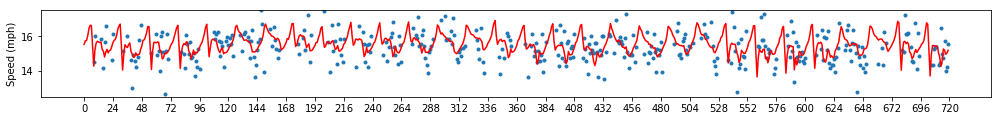

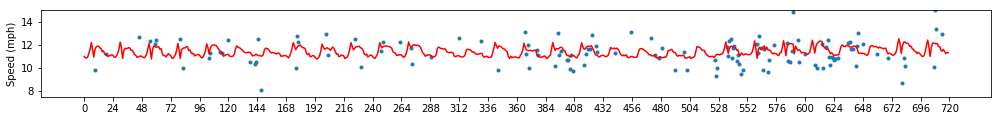

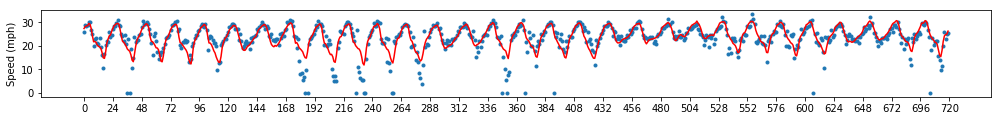

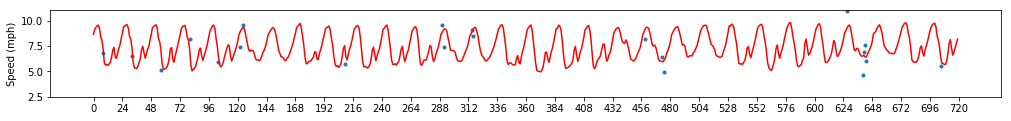

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

for loc in [0, 1, 2, 3]:
    fig = plt.figure(figsize = (15, 1.5))
    ax = fig.add_axes([0.10, 0.18, 0.88, 0.80])
    plt.plot(dense_mat[loc, :], '.', linewidth = 1)
#     plt.plot((dense_mat.sum(0)/(mat != 0).sum(0)), '-', color = 'black', linewidth = 0.8)
    plt.plot(mat[loc, :], color = 'red')
    plt.xticks(np.arange(0, 24 * 30 + 1, 24))
    plt.ylabel('Speed (mph)')
    if loc == 0:
        plt.ylim([12.5, 17.5])
    elif loc == 1:
        plt.ylim([7.5, 15])
    elif loc == 3:
        plt.ylim([2.5, 11])
    plt.show()
#     fig.savefig("../london_movement_speed{}.pdf".format(loc + 1))

In [ ]:
import time
start = time.time()
pred_time_steps = 24 * 7
rank = 10
time_lags = np.array([1, 2, 24])
maxiter = np.array([10, 10, 1000, 100])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = short4cast(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 10
MAPE: 0.0965742
RMSE: 2.36812

Imputation MAPE: 0.0943036
Imputation RMSE: 2.31529

Time step: 40
Time step: 80


## 6 Spatiotemporal Missing Data Imputation


In [26]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = (np.round(random_tensor + 0.5 - missing_rate)
              .reshape([random_tensor.shape[0], random_tensor.shape[1] * random_tensor.shape[2]]))
# =============================================================================

binary_tensor = np.zeros(tensor.shape)
for i1 in range(tensor.shape[0]):
    for i2 in range(tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])

sparse_mat = np.multiply(dense_mat, binary_mat)

In [28]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 10
time_lags = np.array([1, 2, 144])
init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
burn_iter = 100
gibbs_iter = 10
BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 0
MAPE: 0.165788
RMSE: 6.64805

Iter: 1
MAPE: 0.150179
RMSE: 5.77776

Iter: 2
MAPE: 0.139096
RMSE: 5.42406

Iter: 3
MAPE: 0.129952
RMSE: 5.22657

Iter: 4
MAPE: 0.125305
RMSE: 5.32179

Iter: 5
MAPE: 0.119563
RMSE: 4.86867

Iter: 6
MAPE: 0.117971
RMSE: 4.83035

Iter: 7
MAPE: 0.114662
RMSE: 4.7134

Iter: 8
MAPE: 0.113755
RMSE: 4.68393

Iter: 9
MAPE: 0.113566
RMSE: 4.6859

Iter: 10
MAPE: 0.112833
RMSE: 4.65974

Iter: 11
MAPE: 0.11232
RMSE: 4.6435

Iter: 12
MAPE: 0.111664
RMSE: 4.62672

Iter: 13
MAPE: 0.110269
RMSE: 4.58196

Iter: 14
MAPE: 0.109303
RMSE: 4.55448

Iter: 15
MAPE: 0.108269
RMSE: 4.51559

Iter: 16
MAPE: 0.107583
RMSE: 4.49963

Iter: 17
MAPE: 0.107491
RMSE: 4.50368

Iter: 18
MAPE: 0.10726
RMSE: 4.50273

Iter: 19
MAPE: 0.107014
RMSE: 4.5037

Iter: 20
MAPE: 0.106567
RMSE: 4.48777

Iter: 21
MAPE: 0.10584
RMSE: 4.46888

Iter: 22
MAPE: 0.105291
RMSE: 4.45816

Iter: 23
MAPE: 0.105184
RMSE: 4.46099

Iter: 24
MAPE: 0.105175
RMSE: 4.4669

Iter: 25
MAPE: 0.10534
RMSE: 4.47467

Iter:

In [11]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 10
time_lags = np.array([1, 2, 144])
init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
burn_iter = 1000
gibbs_iter = 100
BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iteration: 1
RMSE: 6.62217

Iteration: 2
RMSE: 5.77359

Iteration: 3
RMSE: 5.44082

Iteration: 4
RMSE: 5.00008

Iteration: 5
RMSE: 4.79262

Iteration: 6
RMSE: 4.66538

Iteration: 7
RMSE: 4.66638

Iteration: 8
RMSE: 4.68128

Iteration: 9
RMSE: 4.69583

Iteration: 10
RMSE: 4.69624

Iteration: 11
RMSE: 4.69297

Iteration: 12
RMSE: 4.68732

Iteration: 13
RMSE: 4.59151

Iteration: 14
RMSE: 4.58

Iteration: 15
RMSE: 4.56537

Iteration: 16
RMSE: 4.5631

Iteration: 17
RMSE: 4.53732

Iteration: 18
RMSE: 4.51686

Iteration: 19
RMSE: 4.49638

Iteration: 20
RMSE: 4.47631

Iteration: 21
RMSE: 4.47674

Iteration: 22
RMSE: 4.47925

Iteration: 23
RMSE: 4.47639

Iteration: 24
RMSE: 4.47532

Iteration: 25
RMSE: 4.47382

Iteration: 26
RMSE: 4.47566

Iteration: 27
RMSE: 4.47673

Iteration: 28
RMSE: 4.47795

Iteration: 29
RMSE: 4.47587

Iteration: 30
RMSE: 4.47909

Iteration: 31
RMSE: 4.47597

Iteration: 32
RMSE: 4.48195

Iteration: 33
RMSE: 4.4801

Iteration: 34
RMSE: 4.48533

Iteration: 35
RMSE: 4.4867



Iteration: 279
RMSE: 4.54277

Iteration: 280
RMSE: 4.54823

Iteration: 281
RMSE: 4.54448

Iteration: 282
RMSE: 4.54759

Iteration: 283
RMSE: 4.54091

Iteration: 284
RMSE: 4.54117

Iteration: 285
RMSE: 4.53855

Iteration: 286
RMSE: 4.52926

Iteration: 287
RMSE: 4.53225

Iteration: 288
RMSE: 4.53458

Iteration: 289
RMSE: 4.53542

Iteration: 290
RMSE: 4.53582

Iteration: 291
RMSE: 4.53567

Iteration: 292
RMSE: 4.53448

Iteration: 293
RMSE: 4.53474

Iteration: 294
RMSE: 4.53649

Iteration: 295
RMSE: 4.53865

Iteration: 296
RMSE: 4.53378

Iteration: 297
RMSE: 4.53317

Iteration: 298
RMSE: 4.53296

Iteration: 299
RMSE: 4.5362

Iteration: 300
RMSE: 4.53841

Iteration: 301
RMSE: 4.54266

Iteration: 302
RMSE: 4.5341

Iteration: 303
RMSE: 4.53312

Iteration: 304
RMSE: 4.53327

Iteration: 305
RMSE: 4.53259

Iteration: 306
RMSE: 4.53098

Iteration: 307
RMSE: 4.53154

Iteration: 308
RMSE: 4.53017

Iteration: 309
RMSE: 4.53086

Iteration: 310
RMSE: 4.52925

Iteration: 311
RMSE: 4.52812

Iteration: 3

Iteration: 554
RMSE: 4.53154

Iteration: 555
RMSE: 4.53655

Iteration: 556
RMSE: 4.53213

Iteration: 557
RMSE: 4.53443

Iteration: 558
RMSE: 4.53775

Iteration: 559
RMSE: 4.53351

Iteration: 560
RMSE: 4.53268

Iteration: 561
RMSE: 4.52973

Iteration: 562
RMSE: 4.53173

Iteration: 563
RMSE: 4.53252

Iteration: 564
RMSE: 4.53273

Iteration: 565
RMSE: 4.53034

Iteration: 566
RMSE: 4.53749

Iteration: 567
RMSE: 4.53575

Iteration: 568
RMSE: 4.53442

Iteration: 569
RMSE: 4.53759

Iteration: 570
RMSE: 4.53649

Iteration: 571
RMSE: 4.53511

Iteration: 572
RMSE: 4.54379

Iteration: 573
RMSE: 4.54281

Iteration: 574
RMSE: 4.54175

Iteration: 575
RMSE: 4.54112

Iteration: 576
RMSE: 4.53708

Iteration: 577
RMSE: 4.54077

Iteration: 578
RMSE: 4.5384

Iteration: 579
RMSE: 4.53721

Iteration: 580
RMSE: 4.53381

Iteration: 581
RMSE: 4.53595

Iteration: 582
RMSE: 4.53787

Iteration: 583
RMSE: 4.54146

Iteration: 584
RMSE: 4.53926

Iteration: 585
RMSE: 4.53412

Iteration: 586
RMSE: 4.53718

Iteration: 

Iteration: 828
RMSE: 4.5285

Iteration: 829
RMSE: 4.52419

Iteration: 830
RMSE: 4.52622

Iteration: 831
RMSE: 4.52259

Iteration: 832
RMSE: 4.53048

Iteration: 833
RMSE: 4.53403

Iteration: 834
RMSE: 4.53344

Iteration: 835
RMSE: 4.53256

Iteration: 836
RMSE: 4.53508

Iteration: 837
RMSE: 4.5361

Iteration: 838
RMSE: 4.53511

Iteration: 839
RMSE: 4.5382

Iteration: 840
RMSE: 4.53739

Iteration: 841
RMSE: 4.5374

Iteration: 842
RMSE: 4.53735

Iteration: 843
RMSE: 4.53602

Iteration: 844
RMSE: 4.54409

Iteration: 845
RMSE: 4.54154

Iteration: 846
RMSE: 4.53971

Iteration: 847
RMSE: 4.54041

Iteration: 848
RMSE: 4.54691

Iteration: 849
RMSE: 4.54247

Iteration: 850
RMSE: 4.53421

Iteration: 851
RMSE: 4.53601

Iteration: 852
RMSE: 4.53681

Iteration: 853
RMSE: 4.538

Iteration: 854
RMSE: 4.5377

Iteration: 855
RMSE: 4.53916

Iteration: 856
RMSE: 4.53801

Iteration: 857
RMSE: 4.53592

Iteration: 858
RMSE: 4.54081

Iteration: 859
RMSE: 4.53449

Iteration: 860
RMSE: 4.53554

Iteration: 861
RM

In [21]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 10
time_lags = np.array([1, 2, 144])
init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
burn_iter = 1000
gibbs_iter = 100
BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iteration: 1
RMSE: 6.54248

Iteration: 2
RMSE: 5.76746

Iteration: 3
RMSE: 5.7331

Iteration: 4
RMSE: 5.74967

Iteration: 5
RMSE: 5.48408

Iteration: 6
RMSE: 5.36829

Iteration: 7
RMSE: 4.93222

Iteration: 8
RMSE: 4.70856

Iteration: 9
RMSE: 4.66498

Iteration: 10
RMSE: 4.74202

Iteration: 11
RMSE: 4.69944

Iteration: 12
RMSE: 4.64699

Iteration: 13
RMSE: 4.58376

Iteration: 14
RMSE: 4.56541

Iteration: 15
RMSE: 4.57934

Iteration: 16
RMSE: 4.53475

Iteration: 17
RMSE: 4.54741

Iteration: 18
RMSE: 4.60075

Iteration: 19
RMSE: 4.63094

Iteration: 20
RMSE: 4.59308

Iteration: 21
RMSE: 4.5828

Iteration: 22
RMSE: 4.54219

Iteration: 23
RMSE: 4.51025

Iteration: 24
RMSE: 4.482

Iteration: 25
RMSE: 4.46875

Iteration: 26
RMSE: 4.46078

Iteration: 27
RMSE: 4.45712

Iteration: 28
RMSE: 4.45436

Iteration: 29
RMSE: 4.4563

Iteration: 30
RMSE: 4.45248

Iteration: 31
RMSE: 4.45449

Iteration: 32
RMSE: 4.45683

Iteration: 33
RMSE: 4.4544

Iteration: 34
RMSE: 4.45835

Iteration: 35
RMSE: 4.46065



Iteration: 279
RMSE: 4.5352

Iteration: 280
RMSE: 4.53879

Iteration: 281
RMSE: 4.53062

Iteration: 282
RMSE: 4.53645

Iteration: 283
RMSE: 4.53852

Iteration: 284
RMSE: 4.53585

Iteration: 285
RMSE: 4.52965

Iteration: 286
RMSE: 4.5337

Iteration: 287
RMSE: 4.52432

Iteration: 288
RMSE: 4.5294

Iteration: 289
RMSE: 4.53376

Iteration: 290
RMSE: 4.52812

Iteration: 291
RMSE: 4.5261

Iteration: 292
RMSE: 4.5263

Iteration: 293
RMSE: 4.52704

Iteration: 294
RMSE: 4.52451

Iteration: 295
RMSE: 4.52665

Iteration: 296
RMSE: 4.52461

Iteration: 297
RMSE: 4.52631

Iteration: 298
RMSE: 4.51936

Iteration: 299
RMSE: 4.52083

Iteration: 300
RMSE: 4.51877

Iteration: 301
RMSE: 4.52033

Iteration: 302
RMSE: 4.52117

Iteration: 303
RMSE: 4.52341

Iteration: 304
RMSE: 4.52289

Iteration: 305
RMSE: 4.52642

Iteration: 306
RMSE: 4.52659

Iteration: 307
RMSE: 4.52489

Iteration: 308
RMSE: 4.51955

Iteration: 309
RMSE: 4.52345

Iteration: 310
RMSE: 4.52159

Iteration: 311
RMSE: 4.52437

Iteration: 312


Iteration: 554
RMSE: 4.53142

Iteration: 555
RMSE: 4.52967

Iteration: 556
RMSE: 4.52901

Iteration: 557
RMSE: 4.52616

Iteration: 558
RMSE: 4.5256

Iteration: 559
RMSE: 4.52306

Iteration: 560
RMSE: 4.52195

Iteration: 561
RMSE: 4.52115

Iteration: 562
RMSE: 4.53097

Iteration: 563
RMSE: 4.52992

Iteration: 564
RMSE: 4.52793

Iteration: 565
RMSE: 4.53062

Iteration: 566
RMSE: 4.52713

Iteration: 567
RMSE: 4.53011

Iteration: 568
RMSE: 4.52876

Iteration: 569
RMSE: 4.53496

Iteration: 570
RMSE: 4.53019

Iteration: 571
RMSE: 4.52878

Iteration: 572
RMSE: 4.5281

Iteration: 573
RMSE: 4.53244

Iteration: 574
RMSE: 4.52934

Iteration: 575
RMSE: 4.52825

Iteration: 576
RMSE: 4.53346

Iteration: 577
RMSE: 4.53242

Iteration: 578
RMSE: 4.53382

Iteration: 579
RMSE: 4.53286

Iteration: 580
RMSE: 4.53213

Iteration: 581
RMSE: 4.53003

Iteration: 582
RMSE: 4.52839

Iteration: 583
RMSE: 4.52916

Iteration: 584
RMSE: 4.53061

Iteration: 585
RMSE: 4.52901

Iteration: 586
RMSE: 4.53405

Iteration: 5

Iteration: 829
RMSE: 4.52942

Iteration: 830
RMSE: 4.53005

Iteration: 831
RMSE: 4.53429

Iteration: 832
RMSE: 4.53

Iteration: 833
RMSE: 4.52923

Iteration: 834
RMSE: 4.52564

Iteration: 835
RMSE: 4.52425

Iteration: 836
RMSE: 4.52404

Iteration: 837
RMSE: 4.52049

Iteration: 838
RMSE: 4.52268

Iteration: 839
RMSE: 4.52179

Iteration: 840
RMSE: 4.52469

Iteration: 841
RMSE: 4.52052

Iteration: 842
RMSE: 4.52798

Iteration: 843
RMSE: 4.52719

Iteration: 844
RMSE: 4.52822

Iteration: 845
RMSE: 4.52859

Iteration: 846
RMSE: 4.52124

Iteration: 847
RMSE: 4.52414

Iteration: 848
RMSE: 4.52514

Iteration: 849
RMSE: 4.52461

Iteration: 850
RMSE: 4.5199

Iteration: 851
RMSE: 4.51987

Iteration: 852
RMSE: 4.5177

Iteration: 853
RMSE: 4.52069

Iteration: 854
RMSE: 4.52308

Iteration: 855
RMSE: 4.52469

Iteration: 856
RMSE: 4.52429

Iteration: 857
RMSE: 4.52416

Iteration: 858
RMSE: 4.52467

Iteration: 859
RMSE: 4.52621

Iteration: 860
RMSE: 4.52895

Iteration: 861
RMSE: 4.52379

Iteration: 862


In [13]:
import pandas as pd

dense_mat = pd.read_csv('../datasets/Seattle-data-set/mat.csv', index_col = 0)
RM_mat = pd.read_csv('../datasets/Seattle-data-set/RM_mat.csv', index_col = 0)
dense_mat = dense_mat.values
RM_mat = RM_mat.values

missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = np.round(RM_mat + 0.5 - missing_rate)
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [14]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 50
time_lags = np.array([1, 2, 288])
init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
maxiter1 = 1100
maxiter2 = 100
BTMF(dense_mat, sparse_mat, init, rank, time_lags, maxiter1, maxiter2)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iteration: 1
RMSE: 8.54652

Iteration: 2
RMSE: 8.25793

Iteration: 3
RMSE: 6.82373

Iteration: 4
RMSE: 6.29088

Iteration: 5
RMSE: 6.26116

Iteration: 6
RMSE: 6.11663

Iteration: 7
RMSE: 5.9606

Iteration: 8
RMSE: 5.94366

Iteration: 9
RMSE: 5.90364

Iteration: 10
RMSE: 5.79692

Iteration: 11
RMSE: 5.77708

Iteration: 12
RMSE: 5.75393

Iteration: 13
RMSE: 5.64862

Iteration: 14
RMSE: 5.54195

Iteration: 15
RMSE: 5.47609

Iteration: 16
RMSE: 5.42693

Iteration: 17
RMSE: 5.42135

Iteration: 18
RMSE: 5.41639

Iteration: 19
RMSE: 5.4097

Iteration: 20
RMSE: 5.39612

Iteration: 21
RMSE: 5.3333

Iteration: 22
RMSE: 5.23819

Iteration: 23
RMSE: 5.1996

Iteration: 24
RMSE: 5.18862

Iteration: 25
RMSE: 5.1844

Iteration: 26
RMSE: 5.17956

Iteration: 27
RMSE: 5.17783

Iteration: 28
RMSE: 5.17189

Iteration: 29
RMSE: 5.15882

Iteration: 30
RMSE: 5.13258

Iteration: 31
RMSE: 5.1249

Iteration: 32
RMSE: 5.1116

Iteration: 33
RMSE: 5.07737

Iteration: 34
RMSE: 5.05637

Iteration: 35
RMSE: 5.04501

I

Iteration: 279
RMSE: 4.0684

Iteration: 280
RMSE: 4.06494

Iteration: 281
RMSE: 4.06389

Iteration: 282
RMSE: 4.06309

Iteration: 283
RMSE: 4.06212

Iteration: 284
RMSE: 4.06207

Iteration: 285
RMSE: 4.05934

Iteration: 286
RMSE: 4.0612

Iteration: 287
RMSE: 4.05956

Iteration: 288
RMSE: 4.05898

Iteration: 289
RMSE: 4.06115

Iteration: 290
RMSE: 4.06128

Iteration: 291
RMSE: 4.0611

Iteration: 292
RMSE: 4.0583

Iteration: 293
RMSE: 4.06172

Iteration: 294
RMSE: 4.06312

Iteration: 295
RMSE: 4.06149

Iteration: 296
RMSE: 4.06089

Iteration: 297
RMSE: 4.0614

Iteration: 298
RMSE: 4.06076

Iteration: 299
RMSE: 4.05725

Iteration: 300
RMSE: 4.05363

Iteration: 301
RMSE: 4.05756

Iteration: 302
RMSE: 4.05997

Iteration: 303
RMSE: 4.05964

Iteration: 304
RMSE: 4.05655

Iteration: 305
RMSE: 4.05586

Iteration: 306
RMSE: 4.05818

Iteration: 307
RMSE: 4.05871

Iteration: 308
RMSE: 4.05555

Iteration: 309
RMSE: 4.05488

Iteration: 310
RMSE: 4.05449

Iteration: 311
RMSE: 4.05731

Iteration: 312


/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: covariance is not positive-semidefinite.


Iteration: 394
RMSE: 4.04085

Iteration: 395
RMSE: 4.04268

Iteration: 396
RMSE: 4.0425

Iteration: 397
RMSE: 4.04042

Iteration: 398
RMSE: 4.04092

Iteration: 399
RMSE: 4.03779

Iteration: 400
RMSE: 4.04163

Iteration: 401
RMSE: 4.04327

Iteration: 402
RMSE: 4.0422

Iteration: 403
RMSE: 4.04504

Iteration: 404
RMSE: 4.04549

Iteration: 405
RMSE: 4.04062

Iteration: 406
RMSE: 4.03777

Iteration: 407
RMSE: 4.04032

Iteration: 408
RMSE: 4.03954

Iteration: 409
RMSE: 4.04377

Iteration: 410
RMSE: 4.04143

Iteration: 411
RMSE: 4.03972

Iteration: 412
RMSE: 4.04493

Iteration: 413
RMSE: 4.04041

Iteration: 414
RMSE: 4.03843

Iteration: 415
RMSE: 4.03943

Iteration: 416
RMSE: 4.04237

Iteration: 417
RMSE: 4.03858

Iteration: 418
RMSE: 4.03928

Iteration: 419
RMSE: 4.04381

Iteration: 420
RMSE: 4.04177

Iteration: 421
RMSE: 4.03933

Iteration: 422
RMSE: 4.04199

Iteration: 423
RMSE: 4.03973

Iteration: 424
RMSE: 4.04423

Iteration: 425
RMSE: 4.03968

Iteration: 426
RMSE: 4.04267

Iteration: 4

LinAlgError: Matrix is not positive definite

## 7 Multivariate Time Series Prediction


In [5]:
def BTMF_burn(dense_mat, sparse_mat, init, time_lags, burn_iter):
    
    W = init["W"]
    X = init["X"]
    dim1, dim2 = sparse_mat.shape
    d = time_lags.shape[0]
    pos = np.where((dense_mat != 0) & (sparse_mat == 0))
    position = np.where(sparse_mat != 0)
    binary_mat = np.zeros((dim1, dim2))
    binary_mat[position] = 1
    tau = 1
    for it in range(burn_iter):
        W = sample_factor_w(sparse_mat, binary_mat, W, X, tau)
        A, Sigma = sample_var_coefficient(X, time_lags)
        X = sample_factor_x(sparse_mat, binary_mat, time_lags, W, X, tau, A, inv(Sigma))
        mat_hat = np.matmul(W, X.T)
        tau = sample_precision_tau(sparse_mat, mat_hat, position)
        rmse = np.sqrt(np.sum((dense_mat[pos] - mat_hat[pos]) ** 2) / dense_mat[pos].shape[0])
        if (it + 1) % 1 == 0 and it < burn_iter:
            print('Iteration: {}'.format(it + 1))
            print('RMSE: {:.6}'.format(rmse))
            print()
    return W, X, tau, A

In [6]:
def BTMF_4cast(mat, binary_mat, num_step, time_lags, init, gibbs_iter):
    """Forecast (`4cast`) time series with Bayesian Temporal Matrix Factorization (BTMF)."""
    
    W = init["W"]
    X = init["X"]
    tau = init["tau"]
    A = init["A"]
    rank = W.shape[1]
    d = time_lags.shape[0]
    mat_hat = np.zeros((W.shape[0], num_step, gibbs_iter))
    for it in range(gibbs_iter):
        W = sample_factor_w(mat, binary_mat, W, X, tau)
        A, Sigma = sample_var_coefficient(X, time_lags)
        X = sample_factor_x(sparse_mat, binary_mat, time_lags, W, X, tau, A, inv(Sigma))
        X_new = X.copy()
        for t in range(num_step):
            var = X_new[X.shape[0] + t - 1 - time_lags, :].reshape([rank * d])
            X_new = np.append(X_new, np.matmul(A.T, var).reshape([1, rank]), axis = 0)
#         mat_hat[:, :, it] = np.random.normal(np.matmul(W, X_new[-1 - num_step : -1, :].T), 1 / tau) # dim1 * num_step
        mat_hat[:, :, it] = np.matmul(W, X_new[-1 - num_step : -1, :].T) # dim1 * num_step
    return mat_hat, W, X_new, tau, A

In [7]:
def forecastor(dense_mat, sparse_mat, init, time_lags,
               num_roll, start_time, num_step, burn_iter, gibbs_iter):
    
    W, X, tau, A = BTMF_burn(dense_mat[:, : start_time], sparse_mat[:, : start_time],
                             init, time_lags, burn_iter)
    result = np.zeros((W.shape[0], num_roll * num_step, gibbs_iter))
    for t in range(num_roll):
        mat = sparse_mat[:, : start_time + t * num_step]
        print(mat.shape[1])
        position = np.where(mat != 0)
        binary_mat = mat.copy()
        binary_mat[position] = 1
        init = {"W": W, "X": X, "tau": tau, "A": A}
        mat_hat, W, X, tau, A = BTMF_4cast(mat, binary_mat, 
                                           num_step, time_lags, init, gibbs_iter)
        result[:, t * num_step : (t + 1) * num_step, :] = mat_hat
        
    mat_hat0 = np.mean(result, axis = 2)
    small_dense_mat = dense_mat[:, start_time : dense_mat.shape[1]]
    pos = np.where(small_dense_mat != 0)
    final_mape = np.sum(np.abs(small_dense_mat[pos] - 
                               mat_hat0[pos]) / small_dense_mat[pos]) / small_dense_mat[pos].shape[0]
    final_rmse = np.sqrt(np.sum((small_dense_mat[pos] - 
                                 mat_hat0[pos]) ** 2) / small_dense_mat[pos].shape[0])
    print('Final MAPE: {:.6}'.format(final_mape))
    print('Final RMSE: {:.6}'.format(final_rmse))
    print()
    return result

In [8]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = (np.round(random_tensor + 0.5 - missing_rate)
              .reshape([random_tensor.shape[0], random_tensor.shape[1] * random_tensor.shape[2]]))
# =============================================================================

# binary_tensor = np.zeros(tensor.shape)
# for i1 in range(tensor.shape[0]):
#     for i2 in range(tensor.shape[1]):
#         binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
# binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])

sparse_mat = np.multiply(dense_mat, binary_mat)

In [54]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 10
time_lags = np.array([1, 2, 144])
num_step = 6
num_roll = int(144 * 5 / num_step)
start_time = dim2 - num_roll * num_step
init = {"W": 0.1 * np.random.rand(dim1, rank), 
        "X": 0.1 * np.random.rand(start_time, rank)}
burn_iter = 10
gibbs_iter = 2
result = forecastor(dense_mat, sparse_mat, init, time_lags,
                    num_roll, start_time, num_step, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iteration: 1
RMSE: 5.94597

Iteration: 2
RMSE: 5.74879

Iteration: 3
RMSE: 5.70634

Iteration: 4
RMSE: 5.47132

Iteration: 5
RMSE: 4.99418

Iteration: 6
RMSE: 4.76256

Iteration: 7
RMSE: 4.68645

Iteration: 8
RMSE: 4.5744

Iteration: 9
RMSE: 4.55261

Iteration: 10
RMSE: 4.54463

8064
8070
8076
8082
8088
8094
8100
8106
8112
8118
8124
8130
8136
8142
8148
8154
8160
8166
8172
8178
8184
8190
8196
8202
8208
8214
8220
8226
8232
8238
8244
8250
8256
8262
8268
8274
8280
8286
8292
8298
8304
8310
8316
8322
8328
8334
8340
8346
8352
8358
8364
8370
8376
8382
8388
8394
8400
8406
8412
8418
8424
8430
8436
8442
8448
8454
8460
8466
8472
8478
8484
8490
8496
8502
8508
8514
8520
8526
8532
8538
8544
8550
8556
8562
8568
8574
8580
8586
8592
8598
8604
8610
8616
8622
8628
8634
8640
8646
8652
8658
8664
8670
8676
8682
8688
8694
8700
8706
8712
8718
8724
8730
8736
8742
8748
8754
8760
8766
8772
8778
Final MAPE: 0.372138
Final RMSE: 15.0209

Running time: 762 seconds


In [55]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 10
time_lags = np.array([1, 2, 144])
num_step = 6
num_roll = int(144 * 5 / num_step)
start_time = dim2 - num_roll * num_step
init = {"W": 0.1 * np.random.rand(dim1, rank), 
        "X": 0.1 * np.random.rand(start_time, rank)}
burn_iter = 100
gibbs_iter = 20
result = forecastor(dense_mat, sparse_mat, init, time_lags,
                    num_roll, start_time, num_step, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iteration: 1
RMSE: 5.94449

Iteration: 2
RMSE: 5.75295

Iteration: 3
RMSE: 5.71641

Iteration: 4
RMSE: 5.53581

Iteration: 5
RMSE: 5.0634

Iteration: 6
RMSE: 4.88969

Iteration: 7
RMSE: 4.74457

Iteration: 8
RMSE: 4.68477

Iteration: 9
RMSE: 4.56635

Iteration: 10
RMSE: 4.54667

Iteration: 11
RMSE: 4.53713

Iteration: 12
RMSE: 4.50478

Iteration: 13
RMSE: 4.44558

Iteration: 14
RMSE: 4.41896

Iteration: 15
RMSE: 4.40447

Iteration: 16
RMSE: 4.39169

Iteration: 17
RMSE: 4.3801

Iteration: 18
RMSE: 4.36146

Iteration: 19
RMSE: 4.34012

Iteration: 20
RMSE: 4.323

Iteration: 21
RMSE: 4.2991

Iteration: 22
RMSE: 4.27874

Iteration: 23
RMSE: 4.26798

Iteration: 24
RMSE: 4.26194

Iteration: 25
RMSE: 4.25591

Iteration: 26
RMSE: 4.25072

Iteration: 27
RMSE: 4.24422

Iteration: 28
RMSE: 4.24307

Iteration: 29
RMSE: 4.23493

Iteration: 30
RMSE: 4.22458

Iteration: 31
RMSE: 4.21628

Iteration: 32
RMSE: 4.21207

Iteration: 33
RMSE: 4.21048

Iteration: 34
RMSE: 4.20769

Iteration: 35
RMSE: 4.20458


In [9]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 10
time_lags = np.array([1, 2, 144])
num_step = 6
num_roll = int(144 * 5 / num_step)
start_time = dim2 - num_roll * num_step
init = {"W": 0.1 * np.random.rand(dim1, rank), 
        "X": 0.1 * np.random.rand(start_time, rank)}
burn_iter = 1000
gibbs_iter = 100
result = forecastor(dense_mat, sparse_mat, init, time_lags,
                    num_roll, start_time, num_step, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iteration: 1
RMSE: 5.93895

Iteration: 2
RMSE: 5.75626

Iteration: 3
RMSE: 5.70908

Iteration: 4
RMSE: 5.47771

Iteration: 5
RMSE: 5.05707

Iteration: 6
RMSE: 4.87126

Iteration: 7
RMSE: 4.72067

Iteration: 8
RMSE: 4.6074

Iteration: 9
RMSE: 4.55761

Iteration: 10
RMSE: 4.54906

Iteration: 11
RMSE: 4.54095

Iteration: 12
RMSE: 4.53278

Iteration: 13
RMSE: 4.51274

Iteration: 14
RMSE: 4.48254

Iteration: 15
RMSE: 4.43496

Iteration: 16
RMSE: 4.40604

Iteration: 17
RMSE: 4.39511

Iteration: 18
RMSE: 4.37981

Iteration: 19
RMSE: 4.35406

Iteration: 20
RMSE: 4.32049

Iteration: 21
RMSE: 4.29999

Iteration: 22
RMSE: 4.29119

Iteration: 23
RMSE: 4.28679

Iteration: 24
RMSE: 4.27596

Iteration: 25
RMSE: 4.268

Iteration: 26
RMSE: 4.25774

Iteration: 27
RMSE: 4.25484

Iteration: 28
RMSE: 4.24948

Iteration: 29
RMSE: 4.24814

Iteration: 30
RMSE: 4.24573

Iteration: 31
RMSE: 4.24307

Iteration: 32
RMSE: 4.23946

Iteration: 33
RMSE: 4.23698

Iteration: 34
RMSE: 4.22852

Iteration: 35
RMSE: 4.2246

Iteration: 279
RMSE: 4.17269

Iteration: 280
RMSE: 4.17289

Iteration: 281
RMSE: 4.17093

Iteration: 282
RMSE: 4.16826

Iteration: 283
RMSE: 4.17359

Iteration: 284
RMSE: 4.17055

Iteration: 285
RMSE: 4.17155

Iteration: 286
RMSE: 4.17145

Iteration: 287
RMSE: 4.16986

Iteration: 288
RMSE: 4.16994

Iteration: 289
RMSE: 4.17305

Iteration: 290
RMSE: 4.1739

Iteration: 291
RMSE: 4.17216

Iteration: 292
RMSE: 4.1747

Iteration: 293
RMSE: 4.17331

Iteration: 294
RMSE: 4.17382

Iteration: 295
RMSE: 4.17009

Iteration: 296
RMSE: 4.172

Iteration: 297
RMSE: 4.174

Iteration: 298
RMSE: 4.17279

Iteration: 299
RMSE: 4.17181

Iteration: 300
RMSE: 4.17332

Iteration: 301
RMSE: 4.17236

Iteration: 302
RMSE: 4.17359

Iteration: 303
RMSE: 4.17273

Iteration: 304
RMSE: 4.17165

Iteration: 305
RMSE: 4.17166

Iteration: 306
RMSE: 4.17236

Iteration: 307
RMSE: 4.17234

Iteration: 308
RMSE: 4.17236

Iteration: 309
RMSE: 4.17428

Iteration: 310
RMSE: 4.17245

Iteration: 311
RMSE: 4.17205

Iteration: 312
R

Iteration: 554
RMSE: 4.16119

Iteration: 555
RMSE: 4.15966

Iteration: 556
RMSE: 4.15945

Iteration: 557
RMSE: 4.16213

Iteration: 558
RMSE: 4.15928

Iteration: 559
RMSE: 4.16085

Iteration: 560
RMSE: 4.16203

Iteration: 561
RMSE: 4.16011

Iteration: 562
RMSE: 4.15991

Iteration: 563
RMSE: 4.15951

Iteration: 564
RMSE: 4.1596

Iteration: 565
RMSE: 4.16355

Iteration: 566
RMSE: 4.15974

Iteration: 567
RMSE: 4.15856

Iteration: 568
RMSE: 4.15861

Iteration: 569
RMSE: 4.15716

Iteration: 570
RMSE: 4.15849

Iteration: 571
RMSE: 4.16046

Iteration: 572
RMSE: 4.16011

Iteration: 573
RMSE: 4.15921

Iteration: 574
RMSE: 4.15938

Iteration: 575
RMSE: 4.16154

Iteration: 576
RMSE: 4.16154

Iteration: 577
RMSE: 4.15887

Iteration: 578
RMSE: 4.1588

Iteration: 579
RMSE: 4.15796

Iteration: 580
RMSE: 4.15974

Iteration: 581
RMSE: 4.15819

Iteration: 582
RMSE: 4.15807

Iteration: 583
RMSE: 4.15667

Iteration: 584
RMSE: 4.15733

Iteration: 585
RMSE: 4.15993

Iteration: 586
RMSE: 4.16053

Iteration: 5

Iteration: 828
RMSE: 4.15537

Iteration: 829
RMSE: 4.15485

Iteration: 830
RMSE: 4.15455

Iteration: 831
RMSE: 4.15381

Iteration: 832
RMSE: 4.15293

Iteration: 833
RMSE: 4.15339

Iteration: 834
RMSE: 4.15438

Iteration: 835
RMSE: 4.15388

Iteration: 836
RMSE: 4.15402

Iteration: 837
RMSE: 4.15334

Iteration: 838
RMSE: 4.1554

Iteration: 839
RMSE: 4.15568

Iteration: 840
RMSE: 4.15788

Iteration: 841
RMSE: 4.15639

Iteration: 842
RMSE: 4.15776

Iteration: 843
RMSE: 4.15681

Iteration: 844
RMSE: 4.15712

Iteration: 845
RMSE: 4.15679

Iteration: 846
RMSE: 4.15642

Iteration: 847
RMSE: 4.15971

Iteration: 848
RMSE: 4.15703

Iteration: 849
RMSE: 4.15466

Iteration: 850
RMSE: 4.15552

Iteration: 851
RMSE: 4.15658

Iteration: 852
RMSE: 4.15462

Iteration: 853
RMSE: 4.1566

Iteration: 854
RMSE: 4.15421

Iteration: 855
RMSE: 4.15498

Iteration: 856
RMSE: 4.15379

Iteration: 857
RMSE: 4.15441

Iteration: 858
RMSE: 4.15279

Iteration: 859
RMSE: 4.15556

Iteration: 860
RMSE: 4.15473

Iteration: 8

In [21]:
mat_hat10 = np.percentile(result, 5, axis = 2)
mat_hat90 = np.percentile(result, 95, axis = 2)
mat_hat = np.mean(result, axis = 2)

In [13]:
X = dense_mat.copy()
pred_steps = int(num_roll * num_step)
tv = 144

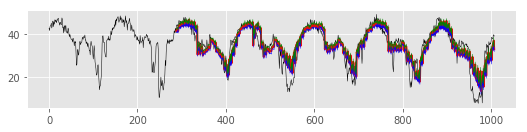

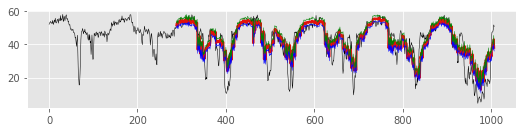

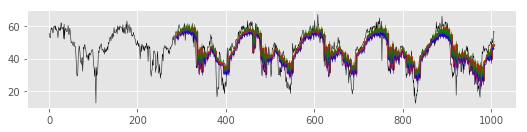

In [28]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
figsize = 2
for i in range(3):
    fig = plt.figure(figsize = (4 * figsize, 1 * figsize))
    ax = fig.add_axes([0.13, 0.28, 0.85, 0.68])
    plt.plot(X[i, 54 * tv :], color = "black", linewidth = 0.5)
    plt.plot(list(range(X.shape[1] - pred_steps - 54 * tv, X.shape[1] - 54 * tv)), 
             mat_hat[i, :], color = "#e3120b", linewidth = 2.0)
    plt.plot(list(range(X.shape[1] - pred_steps - 54 * tv, X.shape[1] - 54 * tv)), 
             mat_hat10[i, :], color = "blue", linewidth = 0.5)
    plt.plot(list(range(X.shape[1] - pred_steps - 54 * tv, X.shape[1] - 54 * tv)), 
             mat_hat90[i, :], color = "green", linewidth = 0.5)

In [29]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = np.round(random_tensor + 0.5 - missing_rate).reshape([random_tensor.shape[0], 
                                                                   random_tensor.shape[1] 
                                                                   * random_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [30]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 10
time_lags = np.array([1, 2, 108])
num_step = 5
num_roll = int(108 * 5 / num_step)
start_time = dim2 - num_roll * num_step
init = {"W": 0.1 * np.random.rand(dim1, rank), 
        "X": 0.1 * np.random.rand(start_time, rank)}
burn_iter = 100
gibbs_iter = 10
result = forecastor(dense_mat, sparse_mat, init, time_lags,
                    num_roll, start_time, num_step, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iteration: 1
RMSE: 101.287

Iteration: 2
RMSE: 70.3381

Iteration: 3
RMSE: 53.6979

Iteration: 4
RMSE: 49.4189

Iteration: 5
RMSE: 47.1461

Iteration: 6
RMSE: 45.86

Iteration: 7
RMSE: 45.7183

Iteration: 8
RMSE: 45.8896

Iteration: 9
RMSE: 46.2484

Iteration: 10
RMSE: 46.7664

Iteration: 11
RMSE: 47.4777

Iteration: 12
RMSE: 47.3682

Iteration: 13
RMSE: 47.5301

Iteration: 14
RMSE: 46.6131

Iteration: 15
RMSE: 45.4952

Iteration: 16
RMSE: 44.8379

Iteration: 17
RMSE: 44.3899

Iteration: 18
RMSE: 44.7274

Iteration: 19
RMSE: 45.0761

Iteration: 20
RMSE: 45.8206

Iteration: 21
RMSE: 45.0064

Iteration: 22
RMSE: 44.4442

Iteration: 23
RMSE: 45.485

Iteration: 24
RMSE: 45.1824

Iteration: 25
RMSE: 44.531

Iteration: 26
RMSE: 44.591

Iteration: 27
RMSE: 44.6757

Iteration: 28
RMSE: 44.9708

Iteration: 29
RMSE: 45.0923

Iteration: 30
RMSE: 45.0159

Iteration: 31
RMSE: 44.904

Iteration: 32
RMSE: 45.3887

Iteration: 33
RMSE: 46.0251

Iteration: 34
RMSE: 45.6158

Iteration: 35
RMSE: 45.502

I

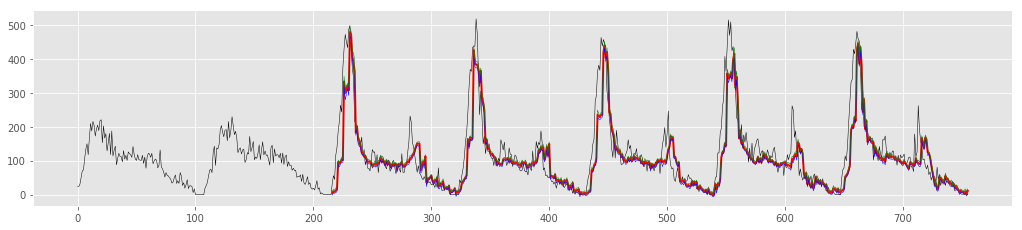

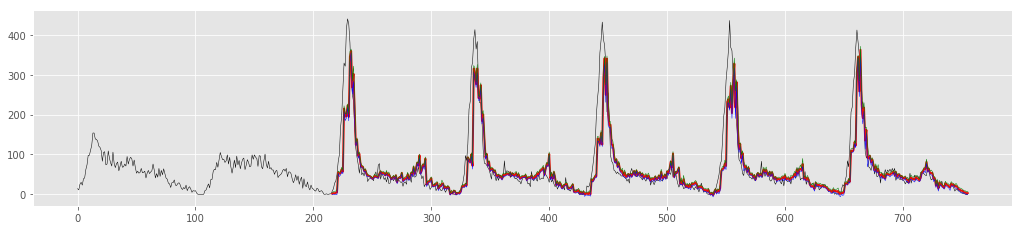

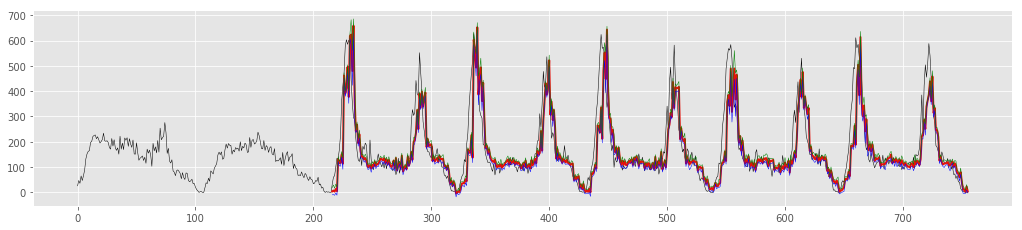

In [32]:
mat_hat10 = np.percentile(result, 10, axis = 2)
mat_hat90 = np.percentile(result, 90, axis = 2)
mat_hat = np.mean(result, axis = 2)

X = dense_mat.copy()
pred_steps = int(num_roll * num_step)
tv = 108

import matplotlib.pyplot as plt
plt.style.use('ggplot')
figsize = 2
for i in range(3):
    fig = plt.figure(figsize = (8 * figsize, 2 * figsize))
    ax = fig.add_axes([0.13, 0.28, 0.85, 0.68])
    plt.plot(X[i, 18 * tv :], color = "black", linewidth = 0.5)
    plt.plot(list(range(X.shape[1] - pred_steps - 18 * tv, X.shape[1] - 18 * tv)), 
             mat_hat[i, :], color = "#e3120b", linewidth = 2.0)
    plt.plot(list(range(X.shape[1] - pred_steps - 18 * tv, X.shape[1] - 18 * tv)), 
             mat_hat10[i, :], color = "blue", linewidth = 0.5)
    plt.plot(list(range(X.shape[1] - pred_steps - 18 * tv, X.shape[1] - 18 * tv)), 
             mat_hat90[i, :], color = "green", linewidth = 0.5)

In [33]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.0

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = np.round(random_tensor + 0.5 - missing_rate).reshape([random_tensor.shape[0], 
                                                                   random_tensor.shape[1] 
                                                                   * random_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [34]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 10
time_lags = np.array([1, 2, 108])
num_step = 5
num_roll = int(108 * 5 / num_step)
start_time = dim2 - num_roll * num_step
init = {"W": 0.1 * np.random.rand(dim1, rank), 
        "X": 0.1 * np.random.rand(start_time, rank)}
burn_iter = 100
gibbs_iter = 10
result = forecastor(dense_mat, sparse_mat, init, time_lags,
                    num_roll, start_time, num_step, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


Iteration: 1
RMSE: nan

Iteration: 2
RMSE: nan

Iteration: 3
RMSE: nan

Iteration: 4
RMSE: nan

Iteration: 5
RMSE: nan

Iteration: 6
RMSE: nan

Iteration: 7
RMSE: nan

Iteration: 8
RMSE: nan

Iteration: 9
RMSE: nan

Iteration: 10
RMSE: nan

Iteration: 11
RMSE: nan

Iteration: 12
RMSE: nan

Iteration: 13
RMSE: nan

Iteration: 14
RMSE: nan

Iteration: 15
RMSE: nan

Iteration: 16
RMSE: nan

Iteration: 17
RMSE: nan

Iteration: 18
RMSE: nan

Iteration: 19
RMSE: nan

Iteration: 20
RMSE: nan

Iteration: 21
RMSE: nan

Iteration: 22
RMSE: nan

Iteration: 23
RMSE: nan

Iteration: 24
RMSE: nan

Iteration: 25
RMSE: nan

Iteration: 26
RMSE: nan

Iteration: 27
RMSE: nan

Iteration: 28
RMSE: nan

Iteration: 29
RMSE: nan

Iteration: 30
RMSE: nan

Iteration: 31
RMSE: nan

Iteration: 32
RMSE: nan

Iteration: 33
RMSE: nan

Iteration: 34
RMSE: nan

Iteration: 35
RMSE: nan

Iteration: 36
RMSE: nan

Iteration: 37
RMSE: nan

Iteration: 38
RMSE: nan

Iteration: 39
RMSE: nan

Iteration: 40
RMSE: nan

Iteration

In [35]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 10
time_lags = np.array([1, 2, 108])
num_step = 5
num_roll = int(108 * 5 / num_step)
start_time = dim2 - num_roll * num_step
init = {"W": 0.1 * np.random.rand(dim1, rank), 
        "X": 0.1 * np.random.rand(start_time, rank)}
burn_iter = 500
gibbs_iter = 50
result = forecastor(dense_mat, sparse_mat, init, time_lags,
                    num_roll, start_time, num_step, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


Iteration: 1
RMSE: nan

Iteration: 2
RMSE: nan

Iteration: 3
RMSE: nan

Iteration: 4
RMSE: nan

Iteration: 5
RMSE: nan

Iteration: 6
RMSE: nan

Iteration: 7
RMSE: nan

Iteration: 8
RMSE: nan

Iteration: 9
RMSE: nan

Iteration: 10
RMSE: nan

Iteration: 11
RMSE: nan

Iteration: 12
RMSE: nan

Iteration: 13
RMSE: nan

Iteration: 14
RMSE: nan

Iteration: 15
RMSE: nan

Iteration: 16
RMSE: nan

Iteration: 17
RMSE: nan

Iteration: 18
RMSE: nan

Iteration: 19
RMSE: nan

Iteration: 20
RMSE: nan

Iteration: 21
RMSE: nan

Iteration: 22
RMSE: nan

Iteration: 23
RMSE: nan

Iteration: 24
RMSE: nan

Iteration: 25
RMSE: nan

Iteration: 26
RMSE: nan

Iteration: 27
RMSE: nan

Iteration: 28
RMSE: nan

Iteration: 29
RMSE: nan

Iteration: 30
RMSE: nan

Iteration: 31
RMSE: nan

Iteration: 32
RMSE: nan

Iteration: 33
RMSE: nan

Iteration: 34
RMSE: nan

Iteration: 35
RMSE: nan

Iteration: 36
RMSE: nan

Iteration: 37
RMSE: nan

Iteration: 38
RMSE: nan

Iteration: 39
RMSE: nan

Iteration: 40
RMSE: nan

Iteration

Iteration: 321
RMSE: nan

Iteration: 322
RMSE: nan

Iteration: 323
RMSE: nan

Iteration: 324
RMSE: nan

Iteration: 325
RMSE: nan

Iteration: 326
RMSE: nan

Iteration: 327
RMSE: nan

Iteration: 328
RMSE: nan

Iteration: 329
RMSE: nan

Iteration: 330
RMSE: nan

Iteration: 331
RMSE: nan

Iteration: 332
RMSE: nan

Iteration: 333
RMSE: nan

Iteration: 334
RMSE: nan

Iteration: 335
RMSE: nan

Iteration: 336
RMSE: nan

Iteration: 337
RMSE: nan

Iteration: 338
RMSE: nan

Iteration: 339
RMSE: nan

Iteration: 340
RMSE: nan

Iteration: 341
RMSE: nan

Iteration: 342
RMSE: nan

Iteration: 343
RMSE: nan

Iteration: 344
RMSE: nan

Iteration: 345
RMSE: nan

Iteration: 346
RMSE: nan

Iteration: 347
RMSE: nan

Iteration: 348
RMSE: nan

Iteration: 349
RMSE: nan

Iteration: 350
RMSE: nan

Iteration: 351
RMSE: nan

Iteration: 352
RMSE: nan

Iteration: 353
RMSE: nan

Iteration: 354
RMSE: nan

Iteration: 355
RMSE: nan

Iteration: 356
RMSE: nan

Iteration: 357
RMSE: nan

Iteration: 358
RMSE: nan

Iteration: 3